In [1]:
import matplotlib.pyplot as plt
import torch

from hysteresis.base import TorchHysteresis
from hysteresis.hybrid import HybridGP

def density_function(mesh_pts):
    x = mesh_pts[:, 0]
    y = mesh_pts[:, 1]
    return torch.exp(-(y - x) / 0.1)

In [2]:
# generate a diagonal scan across 2D input space
train_x = torch.cat([torch.linspace(-1.0, 1.0, 10).reshape(-1, 1)] * 2, dim=1)

# create hysteresis models and set densities
H1 = TorchHysteresis(trainable=False, mesh_scale=0.1, h_min=-1.0)
H2 = TorchHysteresis(trainable=False, mesh_scale=0.1, h_min=-1.0)
H1.hysterion_density = density_function(H1.mesh_points)
H2.hysterion_density = density_function(H2.mesh_points)

# generate training data (magnetization)
hmodels = [H1, H2]
train_m = []
for idx, hyst_model in enumerate(hmodels):
    hyst_model.applied_fields = train_x[:, idx]
    train_m += [hyst_model.predict_magnetization()]
train_m = torch.cat([ele.unsqueeze(1) for ele in train_m], dim=1)

# generate training data (output)
train_y = train_m[:, 0] ** 2 + train_m[:, 1] ** 2

# create and train hybrid model
hgp = HybridGP(train_x, train_y.reshape(-1, 1), hmodels)
hgp.train_model()

# for name, item in hgp.named_parameters():
#     print(f'{name}:{item}')

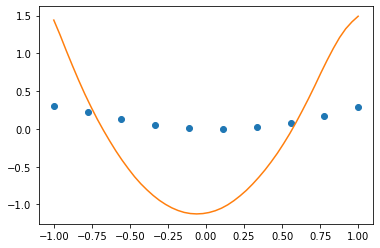

In [3]:
test_x = torch.cat([torch.linspace(-1.0, 1.0, 50).reshape(-1, 1)] * 2, dim=1)
with torch.no_grad():
    post = hgp(test_x)
    mean = post.mean.flatten()
    std = torch.sqrt(post.variance).flatten()

fig, ax = plt.subplots()
ax.plot(train_x[:, 0], train_y.detach(), 'o')
ax.plot(test_x[:, 0], mean, 'C1')
plt.show()

